In [1]:
from ast import literal_eval
from scipy.spatial import distance
from joblib import Parallel, delayed, parallel_backend
import multiprocessing

In [2]:
def bits(n):
    b = []
    while n:
        b = [n & 1] + b
        n >>= 1
    if len(b) < 16:
        for i in range(16 - len(b)):
            b = [0] + b
    return b or [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [3]:
def get_geno_bits(geno,n_sample,num_reg):
    geno_bits = []
    
    for ind in range(n_sample):
        geno_bits.append([])
        for reg in range(num_reg):
            seq = bits(geno[ind * num_reg + reg])
            for bp in range(len(seq)):
                geno_bits[ind].append(seq[bp])
    
    return geno_bits
    

In [4]:
def get_otus(geno_bits,x,n_sample,num_reg):
    av_list = []
    for i in range(n_sample - 1):
        av_list.append(1 + i)
    
    otu = []
    x_otu = []
    
    rep = 0
    while(1):
        tmp = [[item for item in geno_bits[rep]]]
        x_tmp = [x[rep]]
        rm = []
        for i in range(len(av_list)):
            num_diff = distance.cityblock(geno_bits[rep],geno_bits[av_list[i]])
                
            if num_diff/(num_reg * 15) < 0.03:
                tmp.append([item for item in geno_bits[av_list[i]]])
                x_tmp.append(x[av_list[i]])
                rm.append(av_list[i])
                
        otu.append([[item for item in sublist] for sublist in tmp])
        x_otu.append([item for item in x_tmp])
        
        tmp_av_list = []
        for i in range(len(av_list)):
            check = 0
            for j in range(len(rm)):
                if av_list[i] == rm[j]:
                    check = 1
            if check == 0:
                tmp_av_list.append(av_list[i])
        av_list = [tmp_av_list[i] for i in range(len(tmp_av_list))]
        if len(av_list) == 0:
            break
        rep = min(av_list)
        av_list.remove(rep)
    
    rm_otu = []
    for i in range(len(otu)):
        if len(otu[i]) <= 1:
            rm_otu.append(otu[i])
    
    for i in range(len(rm_otu)):
        otu.remove(rm_otu[i])
    
    return [otu,x_otu]

In [5]:
geno=[]
with open('Geno.out','r') as data_file: 
    for line in data_file: 
       geno.append(literal_eval(line))
data_file.close()

In [6]:
pheno=[]
with open('Pheno.out','r') as data_file: 
    for line in data_file: 
       pheno.append(literal_eval(line))
data_file.close()

In [7]:
# Check that genotypes are okay, such that max < 2^16 = 65536
max([max(geno[i]) for i in range(len(geno))])

64592

In [8]:
len(geno)

100

In [9]:
num_reps = len(geno)
num_reg = 100
n_sample = 1000

num_cores = 12

In [10]:
with parallel_backend("loky", inner_max_num_threads=1):
    geno_bits = Parallel(n_jobs=num_cores)(delayed(get_geno_bits)(geno[i],n_sample,num_reg) for i in range(len(geno)))

In [11]:
with parallel_backend("loky", inner_max_num_threads=1):
    otu_res = Parallel(n_jobs=num_cores)(delayed(get_otus)(geno_bits[i],pheno[i],n_sample,num_reg) for i in range(len(geno_bits)))

In [12]:
x_list = [[item for item in otu_res[i][1]] for i in range(len(otu_res))]
g_list = [[[[item for item in sublist] for sublist in otus] for otus in otu_res[rep][0]] for rep in range(len(otu_res)) ]

In [13]:
import matplotlib.pyplot as plt
import math as m

In [29]:
rep = 0

x_rep = [[item for item in sublist] for sublist in x_list[rep]]

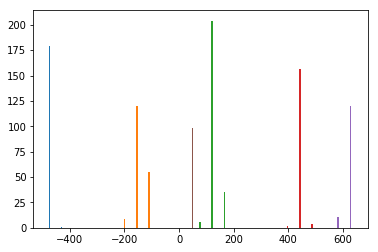

In [30]:
plt.hist(x_rep,25)
plt.show()

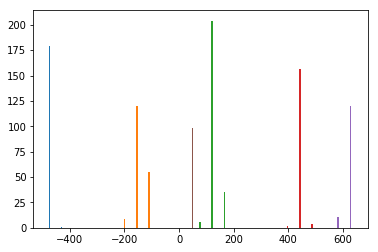

In [31]:
plt.hist(x_rep,25)

plt.savefig('pheno_hist.eps',format='eps',dpi=600)

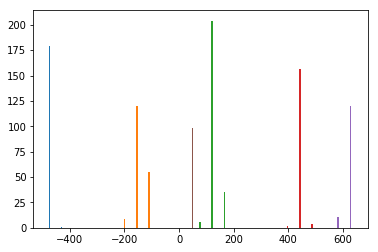

In [32]:
plt.hist(x_rep,25)

plt.savefig('pheno_hist.tiff',format='tiff',dpi=600)

In [33]:
m_x_rep = [sum([x_rep[sp][ind] for ind in range(len(x_rep[sp]))])/len(x_rep[sp]) for sp in range(len(x_rep))]

In [34]:
m_x_rep

[-463.9423485277776,
 -139.33819638043477,
 131.82048035918368,
 440.60618723456815,
 609.2810617633585,
 36.95740986734695]

In [35]:
dist_x_rep = [((m_x_rep[sp1] - m_x_rep[sp2])**2)**0.5 for sp1 in range(len(m_x_rep) - 1) \
              for sp2 in [sp1 + i + 1 for i in range(len(m_x_rep) - (sp1 +1))]]

In [36]:
dist_x_rep

[324.6041521473428,
 595.7628288869613,
 904.5485357623458,
 1073.2234102911361,
 500.89975839512454,
 271.15867673961844,
 579.944383615003,
 748.6192581437932,
 176.29560624778173,
 308.78570687538445,
 477.46058140417483,
 94.86307049183672,
 168.67487452879033,
 403.6487773672212,
 572.3236518960115]

In [37]:
rep = 0

dist_g_rep = [[sum([distance.cityblock(g_list[rep][sp1][ind1],g_list[rep][sp2][ind2])/(len(g_list[rep][sp1])*len(g_list[rep][sp2])) \
                for ind1 in range(len(g_list[rep][sp1])) for ind2 in range(len(g_list[rep][sp2]))]) \
        for sp1 in range(len(g_list[rep]) - 1) for sp2 in [sp1 + i + 1 for i in range(len(g_list[rep]) - (sp1 + 1))]]]

In [38]:
dist_g_rep

[[376.46968599033283,
  382.9682539683079,
  408.88765432099126,
  401.1973706530822,
  394.17154195014234,
  411.1652173912014,
  411.937667740182,
  415.88308994358226,
  127.8891969831367,
  368.8428571427743,
  367.39302071975146,
  411.7513119532875,
  250.14885496184405,
  407.19639707732983,
  413.2449758529843]]

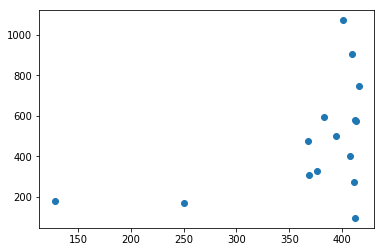

In [39]:
plt.scatter(dist_g_rep,dist_x_rep)
plt.show()

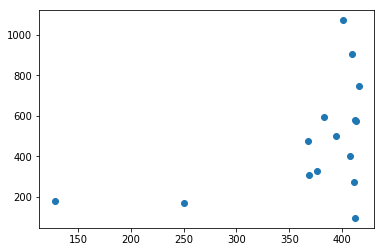

In [40]:
plt.scatter(dist_g_rep,dist_x_rep)

plt.savefig('geno_vs_pheno_dist.eps',format='eps',dpi=600)

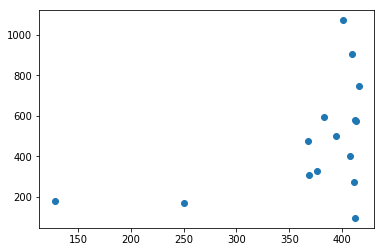

In [41]:
plt.scatter(dist_g_rep,dist_x_rep)

plt.savefig('geno_vs_pheno_dist.tiff',format='tiff',dpi=600)

In [42]:
len(g_list[1])

6

In [43]:
S_list = []
pi_list = []
D_list = []
    
    

for i in range(len(g_list)):
    otu = g_list[i]
    
    loc_S_list = []
    loc_th_list = []
    loc_n_list = []
    loc_D_list = []
    
    for cls in range(len(otu)):
        dist = []
        bp_sum = [0 for i in range(num_reg * 16)]
        for bp in range(num_reg * 16):
            bp_sum[bp] = bp_sum[bp] + otu[cls][len(otu[cls]) - 1][bp]
        for ind1 in range(len(otu[cls]) - 1):
            for indx in range(len(otu[cls]) - (ind1 + 1)):
                ind2 = ind1 + indx + 1
                dist.append(distance.cityblock(otu[cls][ind1],otu[cls][ind2]))
            for bp in range(len(otu[cls][ind1])):
                bp_sum[bp] = bp_sum[bp] + otu[cls][ind1][bp]
        
        n = len(otu[cls])
        
        k = sum(dist)/len(dist)
        
        S = 0
        for bp in range(num_reg * 16):
            if bp_sum[bp] > 0 and bp_sum[bp] < n:
                S = S + 1
        
        a1 = 0
        a2 = 0
        for i in range(n - 1):
            a1 = a1 + 1/(i+1)
            a2 = a2 + 1/((i+1)**2)
        
        b1 = (n + 1)/(3*(n - 1))
        b2 = (2*(n**2 + n + 3))/(9*n*(n - 1))
        c1 = b1 - 1/a1
        c2 = b2 - (n+2)/(a1*n) + a2/(a1**2)
        e1 = c1/a1
        e2 = c2/(a1**2 + a2)
        
        if (e1*S + e2*S*(S - 1)) > 0:
            d = (k - S/a1)/((e1*S + e2*S*(S - 1))**0.5)
        else:
            d = 0
        
        loc_S_list.append(S)
        loc_th_list.append(k)
        loc_D_list.append(d)
    
    S_list.append(loc_S_list)
    pi_list.append(loc_th_list)
    D_list.append(loc_D_list)

In [44]:
x_mean = []

for sublist in x_list:
    for sp in sublist:
        if len(sp) > 1:
            x_mean.append([sum([item for item in sp])/len(sp)])

In [45]:
D_flat = [item for sublist in D_list for item in sublist]
pi_flat = [item for sublist in pi_list for item in sublist]

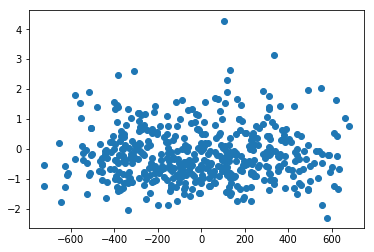

In [46]:
plt.scatter(x_mean,D_flat)
plt.show()

In [47]:
len(g_list[0][0][0])

1600

In [48]:
freq_sp = []
for i in range(50):
    comm_frq_list = []
    for j in range(len(g_list[i])):
        frq_list = [0 for k in range(1600)]
        for k in range(len(g_list[i][j])):
            frq_list = [x + y for x,y in zip(frq_list,g_list[i][j][k])]
        comm_frq_list.append(frq_list)
    freq_sp.append(comm_frq_list)

In [49]:
freq_spect = [[0 for j in range(1000 + 1)] for i in range(1000 + 1)]

In [50]:
for i in range(len(freq_sp)):
    for j in range(len(freq_sp[i]) - 1):
        for l in [j + 1 + m for m in range(len(freq_sp[i]) - 1 - j)]:
            #print([i,j,l])
            for k in range(1600):
                sp_1_count = freq_sp[i][j][k]
                sp_2_count = freq_sp[i][l][k]
                if sp_1_count + sp_2_count > 0:
                    freq_spect[sp_1_count][sp_2_count] = freq_spect[sp_1_count][sp_2_count] + 1

In [51]:
x_flat = []
y_flat = []
z_flat = []
for i in range(len(freq_spect)):
    for j in range(len(freq_spect[0])):
        if freq_spect[i][j] > 0:
            x_flat.append(i)
            y_flat.append(j)
            z_flat.append(m.log10(freq_spect[i][j]))

In [52]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

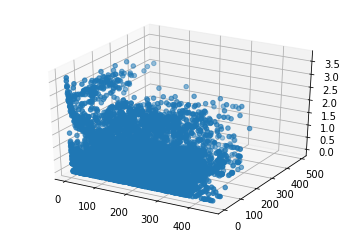

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.scatter(x_flat,y_flat,z_flat)
plt.show()

abundance informative about process

In [54]:
from scipy import linalg
import numpy as np

In [55]:
s_list = []
for i in range(len(freq_sp)):
    freq_spect_loc = [[0 for j in range(1000 + 1)] for i in range(1000 + 1)]
    for j in range(len(freq_sp[i]) - 1):
        for l in [j + 1 + m for m in range(len(freq_sp[i]) - 1 - j)]:
            #print([i,j,l])
            for k in range(1600):
                sp_1_count = freq_sp[i][j][k]
                sp_2_count = freq_sp[i][l][k]
                if sp_1_count + sp_2_count > 0:
                    freq_spect[sp_1_count][sp_2_count] = freq_spect[sp_1_count][sp_2_count] + 1
    U, s, Vh = linalg.svd(np.matrix(freq_spect))
    s_list.append(s)

In [56]:
s_sum = [0 for i in range(1001)]
for i in range(len(s_list)):
    s_sum = [x + y for x,y in zip(s_sum,s_list[i])]

s_mean = [s_sum[i]/len(s_list) for i in range(len(s_sum))]

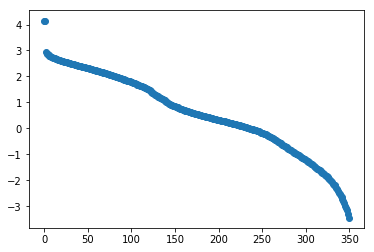

In [59]:
x_val = [i for i in range(350)]
y_val = [m.log10(s_mean[i]) for i in range(350)]

plt.scatter(x_val,y_val)
plt.show()

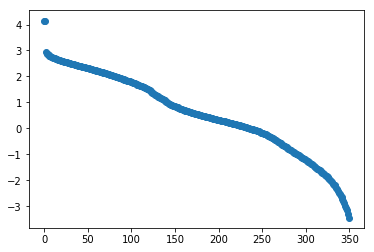

In [60]:
x_val = [i for i in range(350)]
y_val = [m.log10(s_mean[i]) for i in range(350)]

plt.scatter(x_val,y_val)
plt.savefig("SVD.eps",format='eps',dpi=600)

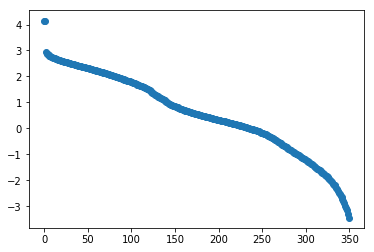

In [61]:
x_val = [i for i in range(350)]
y_val = [m.log10(s_mean[i]) for i in range(350)]

plt.scatter(x_val,y_val)
plt.savefig("SVD.tiff",format='tiff',dpi=600)

In [62]:
U[:,0][350]

-3.366593541113308e-06

In [63]:
Vh[:,0]

array([-0.911584  , -0.41083124, -0.00523511, ...,  0.        ,
        0.        ,  0.        ])

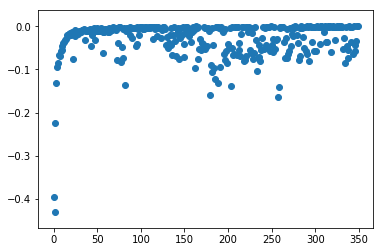

In [64]:
x_val = [i for i in range(350)]
y_val = [U[:,0][i] for i in range(350)]

plt.scatter(x_val,y_val)
plt.show()